<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px"></p>

# Recurrent Neural Network (RNN)


<br>


📈Join our community: https://discord.gg/wXjNPAc5BH

📚Read our book: https://www.amazon.com/gp/product/B09HG18CYL 

🖥️Quantreo's YouTube channel: https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw

In [ ]:
!pip install yfinance
!pip install ta

     |████████████████████████████████| 6.4 MB 7.3 MB/s 
     |████████████████████████████████| 63 kB 285 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=e5d008e1c284a20118d4771a4fc594cf2fd971198b5fb0673c8448a2abeea350
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a98

In [ ]:
import numpy as np
import pandas as pd
import warnings
import yfinance as yf
import ta
warnings.filterwarnings("ignore")

In [ ]:
# The code here will allow you to switch your graphics to dark mode for those who choose to code in dark mode
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

# Features engineering

In [ ]:
def feature_engineering(df):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)
    df_copy["dummy"] = np.round(df_copy["returns"]+0.5)

    # Create the SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # Create the Rsi
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift(1)
    
    return df_copy.dropna()

# Data preparation

In [ ]:
def preprocessing_yf(symbol):
  
  #Import the data
  df = yf.download(symbol).dropna()

  #Rename
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "time"

  # Remove adj close
  del df["adj close"]

  return df

In [ ]:
df = preprocessing_yf("BTC-USD")
dfc = feature_engineering(df)
dfc

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume,returns,dummy,SMA 15,SMA 60,MSD 10,MSD 30,rsi
time,,,,,,,,,,,,
2014-11-16,374.730011,390.799011,374.601990,387.881989,11905600,0.031236,1.0,360.166400,373.194417,0.059374,0.040284,52.526052
2014-11-17,388.348999,410.199005,377.502014,387.407990,41518800,-0.001222,0.0,364.308600,372.036884,0.059454,0.040680,55.885665
2014-11-18,387.785004,392.402008,371.117004,375.197998,32222500,-0.031517,0.0,368.409666,371.419683,0.058641,0.040524,55.714363
2014-11-19,373.895996,386.480988,373.895996,380.554993,18931800,0.014278,1.0,371.585933,371.093050,0.060390,0.040934,51.348107
2014-11-20,380.307007,382.024994,356.781006,357.839996,25233200,-0.059689,0.0,374.923466,370.620567,0.058663,0.040894,53.085274
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-12,42412.300781,42992.550781,41852.574219,42244.468750,18152390304,-0.003855,0.0,40586.609896,43323.429818,0.044252,0.034984,54.878421
2022-02-13,42236.566406,42693.054688,41950.941406,42197.515625,14741589015,-0.001111,0.0,40883.952344,43250.627083,0.040117,0.034522,54.115034
2022-02-14,42157.398438,42775.777344,41681.957031,42586.917969,20827783012,0.009228,1.0,41154.574740,43138.973633,0.040328,0.034452,53.883182


In [ ]:
dfc.columns

Index(['open', 'high', 'low', 'close', 'volume', 'returns', 'SMA 15', 'SMA 60',
       'MSD 10', 'MSD 30', 'rsi'],
      dtype='object')

In [ ]:
# Percentage train set
split = int(0.85*len(dfc))


# Train set creation
X_train = dfc[["SMA 15", "SMA 60", "MSD 10", "MSD 30", "rsi"]].iloc[:split,:]
y_train = dfc[["dummy"]].iloc[:split,:]


# Test set creation
X_test = dfc[["SMA 15", "SMA 60", "MSD 10", "MSD 30", "rsi"]].iloc[split:,:]
y_test = dfc[["dummy"]].iloc[split:,:]

In [ ]:
# STANDARDIZATION
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

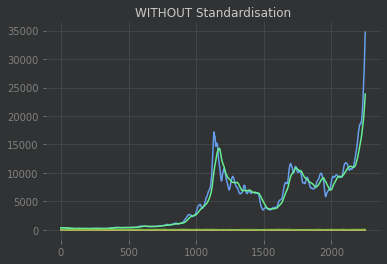

In [ ]:
plt.plot(X_train.values)
plt.title("WITHOUT Standardisation")
plt.show()

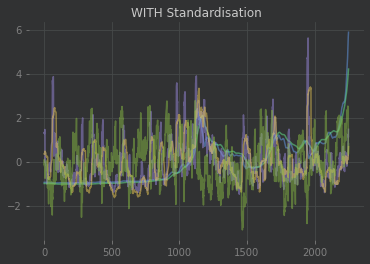

In [ ]:
plt.plot(X_train_sc, alpha=0.5)
plt.title("WITH Standardisation")
plt.show()

# Transform 2-dimensional data to 3-dimensional data

In [ ]:
def X_3d_RNN(X_s, y_s, lag):

    # Simple verification
    if len(X_s) != len(y_s):
        print("Warnings")

    # Create the X_train
    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        X_train.append(X)
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    # Create the y_train
    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    y_train = np.concatenate(y_train, axis=0)
    return X_train, y_train

lag = 15
X_train_3d, y_train_3d = X_3d_RNN(X_train_sc, y_train.values, lag)
X_test_3d, y_test_3d = X_3d_RNN(X_test_sc, y_test.values, lag)

In [ ]:
pd.DataFrame(X_train_3d[0])

,0,1,2,3,4
0,-0.945276,-0.996619,1.306302,0.344290,-0.138809
1,-0.944454,-0.996875,1.310199,0.367896,0.095217
2,-0.943639,-0.997012,1.270535,0.358608,0.083285
3,-0.943008,-0.997084,1.355808,0.383080,-0.220864
4,-0.942345,-0.997189,1.271631,0.380675,-0.099855
5,-0.942102,-0.997340,1.443271,0.464630,-0.618261
6,-0.942081,-0.997529,1.456035,0.471101,-0.759456
7,-0.941942,-0.997835,-0.043979,0.371967,-0.704570
8,-0.941650,-0.998040,0.204899,0.413137,-0.332055
9,-0.941469,-0.998168,0.136114,0.398132,-0.115516


In [ ]:
y_train_3d[0]

array([1.])

# RNN

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

nb_hidden_layer = 3


# INITIALIZATION OF THE MODEL
classifier = Sequential()

# ADD LSTM LAYER
classifier.add(LSTM(units = 10, return_sequences = True,
                    input_shape = (X_train_3d.shape[1],X_train_3d.shape[2],)))


# LOOP WHICH ADD LSTM LAYER
for _ in range(1):
    classifier.add(LSTM(units = 10, return_sequences = True))
    classifier.add(Dropout(0.15))

# LAST LSTM LAYER BUT WITH return_sequences = False 
classifier.add(LSTM(units = 10, return_sequences = False))


# OUTPUT DENSE LAYER
classifier.add(Dense(1, activation="sigmoid"))

# COMPILE THE MODEL
classifier.compile(loss="binary_crossentropy", optimizer="adam")


# TRAINING
early_stop = EarlyStopping(verbose=1, patience = 5)

classifier.fit(X_train_3d, y_train_3d, validation_data=(X_test_3d, y_test_3d), epochs=100, callbacks=[early_stop])

Epoch 1/100
70/70 [==============================] - 11s 42ms/step - loss: 0.6903 - val_loss: 0.6951
Epoch 2/100
70/70 [==============================] - 1s 21ms/step - loss: 0.6860 - val_loss: 0.6952
Epoch 3/100
70/70 [==============================] - 1s 21ms/step - loss: 0.6861 - val_loss: 0.6953
Epoch 4/100
70/70 [==============================] - 1s 21ms/step - loss: 0.6847 - val_loss: 0.6966
Epoch 5/100
70/70 [==============================] - 1s 21ms/step - loss: 0.6846 - val_loss: 0.6963
Epoch 6/100
70/70 [==============================] - 1s 21ms/step - loss: 0.6839 - val_loss: 0.6964
Epoch 6: early stopping


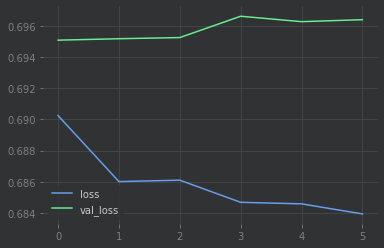

In [ ]:
pd.DataFrame(classifier.history.history).plot()

In [ ]:
# Create predictions for the whole dataset
y_pred_train = np.concatenate((np.zeros([lag,1]),classifier.predict(X_train_3d)),
                                    axis=0)

y_pred_test = np.concatenate((np.zeros([lag,1]),classifier.predict(X_test_3d)),
                                    axis=0)


dfc["prediction"] = np.concatenate((y_pred_train,y_pred_test),
                                    axis=0)

dfc["prediction"] = np.where(dfc["prediction"] < 0.5, -1,1)

# Compute the strategy
dfc["strategy"] =  dfc["prediction"].shift(1) * dfc["returns"]

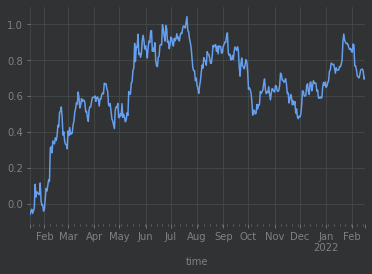

In [ ]:
dfc["strategy"].iloc[split:].cumsum().plot()

# Automatization

In [ ]:
def feature_engineering(df):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)
    df_copy["dummy"] = np.round(df_copy["returns"]+0.5)

    # Create the SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # Create the Rsi
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift(1)
    
    return df_copy.dropna()

def preprocessing_yf(symbol):
  
  #Import the data
  df = yf.download(symbol).dropna()

  #Rename
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "time"

  # Remove adj close
  del df["adj close"]

  return df


def X_3d_RNN(X_s, y_s, lag):

    # Simple verification
    if len(X_s) != len(y_s):
        print("Warnings")

    # Create the X_train
    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        X_train.append(X)
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    # Create the y_train
    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    y_train = np.concatenate(y_train, axis=0)
    return X_train, y_train


import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def RNN(symbol, nb_neurons=10, nb_hidden_layer=1, lag=15, nb_model=None):
  
  df = yf.download("BTC-USD")[["Open", "High", "Low", "Adj Close", "Volume"]]
  df.columns = ["open", "high", "low", "close", "volume"]
  dfc = feature_engineering(df)


  # Percentage train set
  split = int(0.80*len(dfc))
  split_val = int(0.90*len(dfc))
 
  # Train set creation
  X_train = dfc[['SMA 15', 'SMA 60',
        'MSD 10', 'MSD 30', 'rsi']].iloc[:split,:]
  y_train = dfc[["dummy"]].iloc[:split]


  # Test set creation
  X_test = dfc[['SMA 15', 'SMA 60',
        'MSD 10', 'MSD 30', 'rsi']].iloc[split:,:]
  y_test = dfc[["dummy"]].iloc[split:]

  # STANDARDISATION
  from sklearn.preprocessing import StandardScaler

  sc = StandardScaler()

  X_train_sc = sc.fit_transform(X_train)
  X_test_sc = sc.transform(X_test)

  # Transform 2-dimensional data to 3-dimensional data
  X_train_3d, y_train_3d = X_3d_RNN(X_train_sc, y_train.values, lag)
  X_test_3d, y_test_3d = X_3d_RNN(X_test_sc, y_test.values, lag)

  # INITIALIZATION OF THE MODEL
  classifier = Sequential()

  # ADD LSTM LAYER
  classifier.add(LSTM(units = nb_neurons, return_sequences = True,
                      input_shape = (X_train_3d.shape[1],X_train_3d.shape[2],)))


  # LOOP WHICH ADD LSTM LAYER
  for _ in range(nb_hidden_layer):
      classifier.add(LSTM(units = nb_neurons, return_sequences = True))
      classifier.add(Dropout(0.20))

  # LAST LSTM LAYER BUT WITH return_sequences = False 
  classifier.add(LSTM(units = nb_neurons, return_sequences = False))


  # OUTPUT DENSE LAYER
  classifier.add(Dense(1, activation="sigmoid"))

  # COMPILE THE MODEL
  classifier.compile(loss="binary_crossentropy", optimizer="adam")


  # TRAINING
  early_stop = EarlyStopping(verbose=1, patience = 5)
  classifier.fit(X_train_3d, y_train_3d, validation_data=(X_test_3d, y_test_3d),
                 epochs=1, callbacks=[early_stop])
  
  # Create predictions for the whole dataset
  y_pred_train = np.concatenate((np.zeros([lag,1]),classifier.predict(X_train_3d)),
                                      axis=0)

  y_pred_test = np.concatenate((np.zeros([lag,1]),classifier.predict(X_test_3d)),
                                      axis=0)

  dfc["prediction"] = np.concatenate((y_pred_train,y_pred_test),
                                      axis=0)

  dfc["prediction"] = np.where(dfc["prediction"] < 0.5, -1,1)

  # Compute the strategy
  dfc["strategy"] = np.sign(dfc["prediction"]) * dfc["returns"]

  if nb_model!=None:
    classifier.save_weights(f"Weights_RNN/RNN n°{nb_model}")
    return dfc["strategy"].iloc[split+lag:split_val], dfc["strategy"].iloc[split_val:]

  else:
      return dfc["strategy"].iloc[split+lag:split_val], dfc["strategy"].iloc[split_val:]

In [ ]:
sr = RNN("BTC-USD", nb_model=15)

sr

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
66/66 [==============================] - 9s 43ms/step - loss: 0.6915 - val_loss: 0.6919
Epoch 2/100
66/66 [==============================] - 1s 21ms/step - loss: 0.6885 - val_loss: 0.6923
Epoch 3/100
66/66 [==============================] - 1s 22ms/step - loss: 0.6867 - val_loss: 0.6930
Epoch 4/100
66/66 [==============================] - 1s 21ms/step - loss: 0.6861 - val_loss: 0.6934
Epoch 5/100
66/66 [==============================] - 1s 21ms/step - loss: 0.6854 - val_loss: 0.6936
Epoch 6/100
66/66 [==============================] - 1s 21ms/step - loss: 0.6851 - val_loss: 0.6923
Epoch 6: early stopping


(Date
 2020-09-20    0.014068
 2020-09-21    0.043518
 2020-09-22   -0.007283
 2020-09-23    0.027734
 2020-09-24   -0.050153
                 ...   
 2021-05-23   -0.073689
 2021-05-24    0.113182
 2021-05-25   -0.007848
 2021-05-26    0.023227
 2021-05-27   -0.021816
 Name: strategy, Length: 250, dtype: float64, Date
 2021-05-28   -0.071269
 2021-05-29   -0.030297
 2021-05-30    0.030681
 2021-05-31    0.046379
 2021-06-01   -0.017355
                 ...   
 2022-02-12   -0.003855
 2022-02-13   -0.001111
 2022-02-14    0.009228
 2022-02-15    0.046688
 2022-02-16   -0.007493
 Name: strategy, Length: 265, dtype: float64)

In [ ]:
# Library to estimate the time until the end of the loop
from tqdm import tqdm

# Empty lists to contain the returns
returns_test = []
returns_val = []


# Compute the returns during the test and validation periods
for i in tqdm(range(100)):
  test, val = RNN("BTC-USD", nb_model=i)
  returns_test.append(test)
  returns_val.append(val)

  0%|          | 0/100 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 42ms/step - loss: 0.6891 - val_loss: 0.6920


  1%|          | 1/100 [00:13<22:00, 13.34s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 42ms/step - loss: 0.6885 - val_loss: 0.6925


  2%|▏         | 2/100 [00:25<20:51, 12.77s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 45ms/step - loss: 0.6900 - val_loss: 0.6944


  3%|▎         | 3/100 [00:39<21:34, 13.35s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 8s 41ms/step - loss: 0.6891 - val_loss: 0.6918


  4%|▍         | 4/100 [00:51<20:24, 12.75s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6888 - val_loss: 0.6943


  5%|▌         | 5/100 [01:03<19:37, 12.39s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 10s 43ms/step - loss: 0.6910 - val_loss: 0.6914


  6%|▌         | 6/100 [01:15<19:25, 12.39s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6908 - val_loss: 0.6934


  7%|▋         | 7/100 [01:28<19:09, 12.36s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 52ms/step - loss: 0.6913 - val_loss: 0.6903


  8%|▊         | 8/100 [01:42<19:56, 13.00s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 8s 42ms/step - loss: 0.6889 - val_loss: 0.6910


  9%|▉         | 9/100 [01:53<18:56, 12.49s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 10s 44ms/step - loss: 0.6914 - val_loss: 0.6928


 10%|█         | 10/100 [02:08<19:36, 13.07s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 44ms/step - loss: 0.6925 - val_loss: 0.6899


 11%|█         | 11/100 [02:20<19:03, 12.85s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 54ms/step - loss: 0.6904 - val_loss: 0.6934


 12%|█▏        | 12/100 [02:33<18:58, 12.94s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6913 - val_loss: 0.6927


 13%|█▎        | 13/100 [02:45<18:11, 12.54s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 42ms/step - loss: 0.6898 - val_loss: 0.6914


 14%|█▍        | 14/100 [02:59<18:37, 12.99s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 10s 43ms/step - loss: 0.6885 - val_loss: 0.6895


 15%|█▌        | 15/100 [03:12<18:35, 13.12s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 10s 44ms/step - loss: 0.6917 - val_loss: 0.6946


 16%|█▌        | 16/100 [03:25<18:15, 13.05s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 44ms/step - loss: 0.6895 - val_loss: 0.6923


 17%|█▋        | 17/100 [03:39<18:29, 13.37s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6925 - val_loss: 0.6957


 18%|█▊        | 18/100 [03:52<18:13, 13.33s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 10s 43ms/step - loss: 0.6895 - val_loss: 0.6917


 19%|█▉        | 19/100 [04:07<18:25, 13.65s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6892 - val_loss: 0.6949


 20%|██        | 20/100 [04:19<17:41, 13.27s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 53ms/step - loss: 0.6918 - val_loss: 0.6905


 21%|██        | 21/100 [04:31<17:04, 12.97s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 44ms/step - loss: 0.6900 - val_loss: 0.6930


 22%|██▏       | 22/100 [04:43<16:23, 12.61s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6879 - val_loss: 0.7001


 23%|██▎       | 23/100 [04:57<16:41, 13.01s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 42ms/step - loss: 0.6898 - val_loss: 0.6930


 24%|██▍       | 24/100 [05:09<16:10, 12.77s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 42ms/step - loss: 0.6888 - val_loss: 0.6957


 25%|██▌       | 25/100 [05:23<16:17, 13.03s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 42ms/step - loss: 0.6921 - val_loss: 0.6918


 26%|██▌       | 26/100 [05:35<15:43, 12.75s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6900 - val_loss: 0.6917


 27%|██▋       | 27/100 [05:47<15:05, 12.40s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 10s 43ms/step - loss: 0.6910 - val_loss: 0.6955


 28%|██▊       | 28/100 [05:59<14:57, 12.46s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 42ms/step - loss: 0.6902 - val_loss: 0.6925


 29%|██▉       | 29/100 [06:11<14:37, 12.36s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 8s 41ms/step - loss: 0.6894 - val_loss: 0.6910


 30%|███       | 30/100 [06:25<14:51, 12.74s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6887 - val_loss: 0.6941


 31%|███       | 31/100 [06:38<14:47, 12.86s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6891 - val_loss: 0.6896


 32%|███▏      | 32/100 [06:51<14:24, 12.71s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6912 - val_loss: 0.6900


 33%|███▎      | 33/100 [07:04<14:33, 13.03s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 8s 42ms/step - loss: 0.6892 - val_loss: 0.6926


 34%|███▍      | 34/100 [07:18<14:30, 13.19s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 8s 43ms/step - loss: 0.6893 - val_loss: 0.6911


 35%|███▌      | 35/100 [07:29<13:40, 12.63s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 10s 44ms/step - loss: 0.6891 - val_loss: 0.6969


 36%|███▌      | 36/100 [07:42<13:31, 12.68s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6902 - val_loss: 0.6909


 37%|███▋      | 37/100 [07:56<13:42, 13.06s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 8s 42ms/step - loss: 0.6908 - val_loss: 0.6952


 38%|███▊      | 38/100 [08:10<13:40, 13.24s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 8s 42ms/step - loss: 0.6927 - val_loss: 0.6909


 39%|███▉      | 39/100 [08:21<12:57, 12.75s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 10s 44ms/step - loss: 0.6890 - val_loss: 0.7005


 40%|████      | 40/100 [08:35<13:08, 13.15s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 10s 47ms/step - loss: 0.6905 - val_loss: 0.6912


 41%|████      | 41/100 [08:49<13:08, 13.37s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 8s 42ms/step - loss: 0.6908 - val_loss: 0.6910


 42%|████▏     | 42/100 [09:01<12:28, 12.91s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 8s 42ms/step - loss: 0.6904 - val_loss: 0.6931


 43%|████▎     | 43/100 [09:14<12:17, 12.94s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6914 - val_loss: 0.6966


 44%|████▍     | 44/100 [09:27<11:58, 12.83s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 10s 45ms/step - loss: 0.6907 - val_loss: 0.6903


 45%|████▌     | 45/100 [09:41<12:06, 13.20s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 8s 42ms/step - loss: 0.6890 - val_loss: 0.7023


 46%|████▌     | 46/100 [09:55<12:03, 13.40s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6881 - val_loss: 0.6933


 47%|████▋     | 47/100 [10:08<11:45, 13.30s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 42ms/step - loss: 0.6887 - val_loss: 0.6997


 48%|████▊     | 48/100 [10:22<11:41, 13.48s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 9s 43ms/step - loss: 0.6891 - val_loss: 0.6926


 49%|████▉     | 49/100 [10:35<11:31, 13.56s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 8s 42ms/step - loss: 0.6900 - val_loss: 0.6938


 50%|█████     | 50/100 [10:47<10:56, 13.13s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 8s 43ms/step - loss: 0.6915 - val_loss: 0.6926


 51%|█████     | 51/100 [11:00<10:41, 13.08s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - 10s 42ms/step - loss: 0.6964 - val_loss: 0.6980


 52%|█████▏    | 52/100 [11:15<10:43, 13.40s/it]

[*********************100%***********************]  1 of 1 completed
66/66 [==============================] - ETA: 0s - loss: 0.6925

 52%|█████▏    | 52/100 [11:24<10:32, 13.17s/it]


KeyboardInterrupt: ignored

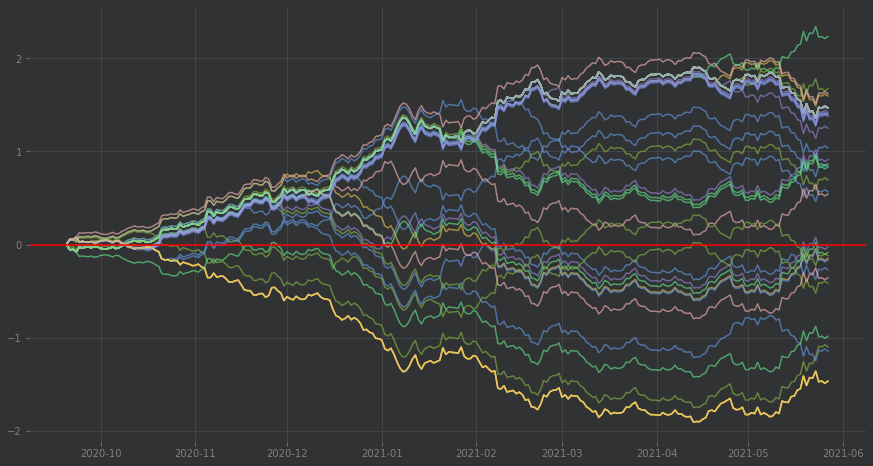

In [ ]:
""" IT IS NOT A MONTE CARLO SIMULATION """

# Organize well all the data
RNN_returns = pd.DataFrame(returns_test, index=[f"RNN n°{i}" for i in range(len(returns_test))]).transpose()

# Adapt the size of the graph
plt.figure(figsize=(15,8))

# Plot the returns
plt.plot(RNN_returns.cumsum(axis=0), alpha=0.6)

# Plot break-even line
plt.axhline(0, color="red")

# show the graph
plt.show()

# Create a criterion

In [ ]:
def drawdown_function(serie):

  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum() + 1

  # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown = cum/running_max - 1
  return drawdown

In [ ]:
# Create empty dataframe
values = pd.DataFrame(index=["ret/dd", "ret", "dd"])

# Compute return and max drawdawn for each ANN
for col in RNN_returns.columns:

  # Compute the returns and the max drawdown for one ANN
  ret, dd = RNN_returns[col].cumsum().iloc[-1], -np.min(drawdown_function(RNN_returns[col]))

  # Create a column containing the ret/dd ratio, the returns and the drawdown
  values[col] = ret/dd, ret, dd

In [ ]:
values.transpose().sort_values(by="ret/dd", ascending=False)

,ret/dd,ret,dd
RNN n°31,19.943383,2.232328,0.111933
RNN n°34,14.942743,1.672590,0.111933
RNN n°3,9.720222,1.594739,0.164064
RNN n°23,9.110240,1.622201,0.178063
RNN n°36,7.818727,1.466737,0.187593
RNN n°13,7.813835,1.466127,0.187632
RNN n°27,7.813835,1.466127,0.187632
RNN n°43,7.813835,1.466127,0.187632
RNN n°28,7.813835,1.466127,0.187632
RNN n°29,7.813835,1.466127,0.187632


In [ ]:
RNN_models = list(values.transpose().sort_values(by="ret/dd", ascending=False).index[0:3])

In [ ]:
RNN_models

['RNN n°31', 'RNN n°34', 'RNN n°3']

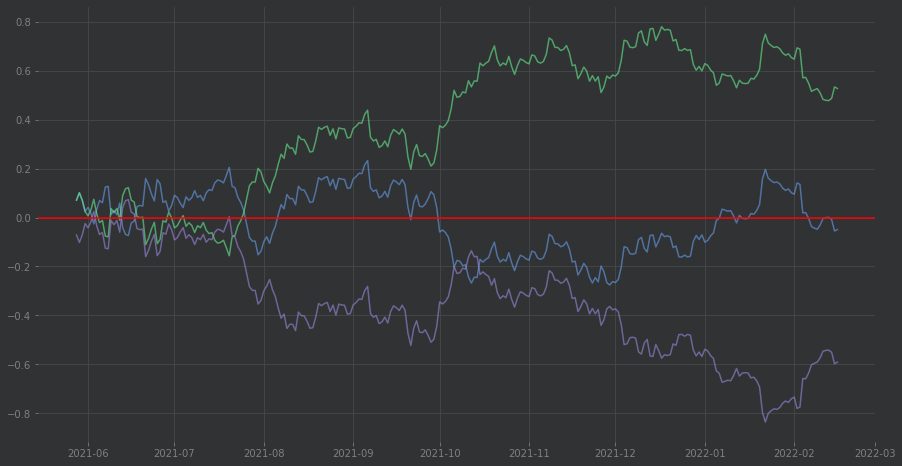

In [ ]:
""" Use the 3best models on the test set to trade on the validation set"""

# Organize the data 
RNN_val = pd.DataFrame(returns_val, index=[f"RNN n°{i}" for i in range(len(returns_val))]).transpose()

# Adapt the size
plt.figure(figsize=(15,8))

# Plot the portfolio method containing the 10 best strategies
plt.plot(RNN_val[RNN_models].cumsum(axis=0), alpha=0.6)

plt.axhline(0, color="red")

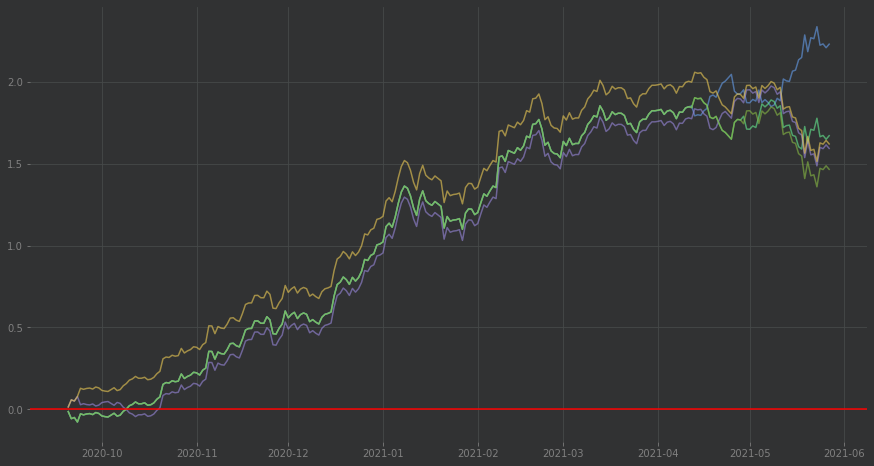

In [ ]:
""" Use the 3best models on the test set to trade on the test set"""

# Organize the data 
RNN_val = pd.DataFrame(returns_val, index=[f"RNN n°{i}" for i in range(len(returns_val))]).transpose()

# Adapt the size
plt.figure(figsize=(15,8))

# Plot the portfolio method containing the 10 best strategies
plt.plot(RNN_returns[RNN_models].cumsum(axis=0), alpha=0.6)

plt.axhline(0, color="red")

# Bagging method

In [ ]:
def RNN_weights():
  # INITIALIZATION OF THE MODEL
  classifier = Sequential()

  # ADD LSTM LAYER
  classifier.add(LSTM(units = 10, return_sequences = True,
                      input_shape = (X_train_3d.shape[1],X_train_3d.shape[2],)))


  # LOOP WHICH ADD LSTM LAYER
  for _ in range(1):
      classifier.add(LSTM(units = 10, return_sequences = True))
      classifier.add(Dropout(0.50))

  # LAST LSTM LAYER BUT WITH return_sequences = False 
  classifier.add(LSTM(units = 10, return_sequences = False))


  # OUTPUT DENSE LAYER
  classifier.add(Dense(1, activation="sigmoid"))

  # COMPILE THE MODEL
  classifier.compile(loss="binary_crossentropy", optimizer="adam")

  return classifier

In [ ]:
# Create empty dataframe
prediction = pd.DataFrame(index = dfc.index)
for nb in RNN_models:

  # Create ANN structure
  rnn = RNN_weights()

  # Import trained weights
  rnn.load_weights(f"Weights_RNN/{nb}")

  # Create predictions for the whole dataset
  
  y_pred_train = np.concatenate((np.zeros([lag,1]),rnn.predict(X_train_3d)),
                                    axis=0)

  y_pred_test = np.concatenate((np.zeros([lag,1]),rnn.predict(X_test_3d)),
                                    axis=0)


  pre = np.concatenate((y_pred_train,y_pred_test),
                                    axis=0)

  prediction[f"{nb}"] = pre
prediction

,RNN n°31,RNN n°34,RNN n°3
time,,,
2014-11-16,0.000000,0.000000,0.000000
2014-11-17,0.000000,0.000000,0.000000
2014-11-18,0.000000,0.000000,0.000000
2014-11-19,0.000000,0.000000,0.000000
2014-11-20,0.000000,0.000000,0.000000
...,...,...,...
2022-02-12,0.492287,0.519987,0.497671
2022-02-13,0.492768,0.522389,0.497467
2022-02-14,0.493456,0.524009,0.497351


In [ ]:
prediction["Increase"] = (np.sign(prediction-0.5)==1).sum(axis=1)
prediction["Decrease"] = (np.sign(prediction-0.5)==-1).sum(axis=1)

,RNN n°31,RNN n°34,RNN n°3,Increase,Decrease
time,,,,,
2014-11-16,0.000000,0.000000,0.000000,0,4
2014-11-17,0.000000,0.000000,0.000000,0,4
2014-11-18,0.000000,0.000000,0.000000,0,4
2014-11-19,0.000000,0.000000,0.000000,0,4
2014-11-20,0.000000,0.000000,0.000000,0,4
...,...,...,...,...,...
2022-02-12,0.492287,0.519987,0.497671,1,2
2022-02-13,0.492768,0.522389,0.497467,1,2
2022-02-14,0.493456,0.524009,0.497351,1,2


In [ ]:
# Delete the rows containing only some 0
prediction = prediction.iloc[lag:,:]
prediction

,RNN n°31,RNN n°34,RNN n°3,Increase,Decrease,returns,position,strategy
time,,,,,,,,
2014-12-16,0.537507,0.535178,0.552034,3,0,-0.052941,1.0,-0.052941
2014-12-17,0.536451,0.535242,0.551838,3,0,-0.022277,1.0,-0.022277
2014-12-18,0.535062,0.535583,0.551387,3,0,-0.026206,1.0,-0.026206
2014-12-19,0.533163,0.535829,0.550555,3,0,0.020704,1.0,0.020704
2014-12-20,0.531547,0.536140,0.549744,3,0,0.038110,1.0,0.038110
...,...,...,...,...,...,...,...,...
2022-02-12,0.492287,0.519987,0.497671,1,2,-0.003855,-1.0,0.003855
2022-02-13,0.492768,0.522389,0.497467,1,2,-0.001111,-1.0,0.001111
2022-02-14,0.493456,0.524009,0.497351,1,2,0.009228,-1.0,-0.009228


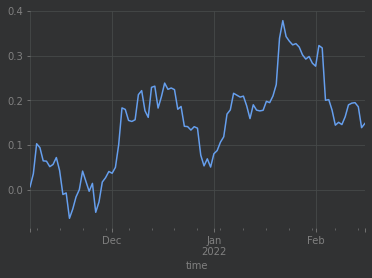

In [ ]:
# Put the daily return of the asset
prediction["returns"] = dfc["returns"]

# Compute the position doing a bagging on the best ANN
prediction["position"] = np.nan
prediction.loc[prediction["Increase"] > prediction["Decrease"], "position"] = 1
prediction.loc[prediction["Increase"] < prediction["Decrease"], "position"] = -1

# When you will run again the code you can have different results
# Compute and plot the strategy return on the validation test
# Very important to put the shift at he position,Don't forget!
prediction["strategy"] = prediction["returns"] * prediction["position"].shift(1)
split, split_val = int(0.85*len(dfc)), int(0.95*len(dfc))
prediction["strategy"].iloc[split_val:].cumsum().plot()